In [2]:
import os
import numpy as np
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis,PCA
import re
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Предобработка данных

In [181]:
# Указываем полный путь к базе данных на диске D
db_path = r'D:\DO_NOT_REMOVE\Data_Analyst_Junior\FP\result_data\shop_database.db'

# Проверяем, существует ли файл базы данных
if os.path.exists(db_path):
    # Подключаемся к базе данных
    conn = sqlite3.connect(db_path)

    # Создаем курсор для выполнения SQL-запросов
    cursor = conn.cursor()

    # Пример выполнения SQL-запроса (получение всех таблиц в базе)
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    # Получаем результат
    tables = cursor.fetchall()
    if tables:
        print("Таблицы базы данных:")
        for table in tables:
            print(table[0])
        
        unique_tables = list(set(table[0] for table in tables))
        dataframes = {}
        for table in unique_tables:
            table_name = f"{table}_df"
            query = f"SELECT * FROM {table}" 
            dataframes[table_name] = pd.read_sql_query(query, conn)
       
        # Создаем отдельные переменные для каждого DataFrame
        for table_name, df in dataframes.items():
            locals()[table_name] = df
            
        # Создаем список всех созданных DataFrame
        list_of_dfs = list(dataframes.keys())
        print("Список всех созданных DataFrame:")
        for df_name in list_of_dfs:
            df = dataframes[df_name]  # Получаем DataFrame по имени ключа
            print(df_name)
            # Сохранить каждый DataFrame в файл с именем {df_name}.csv
            file_path = fr'D:\DO_NOT_REMOVE\Data_Analyst_Junior\FP\{df_name}.csv'
            df.to_csv(file_path, index=False)
    else:
        print("В базе данных таблиц не найдено.")

    # Закрываем соединение с базой данных
    conn.close()
else:
    print(f"База данных по пути {db_path} не найдена.")

Таблицы базы данных:
purchases
personal_data_coeffs
personal_data
Список всех созданных DataFrame:
personal_data_coeffs_df
personal_data_df
purchases_df


personal_data — ID клиентов, их пол, возраст, образование, страна и город проживания;

personal_data_coeffs — данные с персональными коэффициентами клиентов, которые рассчитываются по некоторой закрытой схеме (вам потребуется коэффициент personal_coef);

purchases — данные о покупках: ID покупателя, название товара, цвет, стоимость, гендерная принадлежность потенциальных покупателей товара, наличие скидки (поле base_sale. Значение 1 соответствует наличию скидки на момент покупки) и дата покупки.

In [182]:
# Рассчитываем базовые показатели качества данных
def calculate_quality_metrics(df):
    metrics = {}
    metrics['Пропуски'] = df.isna().sum()
    metrics['Процент ропущенных значений'] = df.isna().mean() * 100
    metrics['Уникальные значения'] = df.nunique()
    metrics['Дубликаты'] = df.duplicated().sum()
    return pd.DataFrame(metrics)

 ### Восстановление закрытых утерянных данных (пол покупателей).

In [183]:
personal_data_ext_df = pd.read_csv(r'D:\DO_NOT_REMOVE\Data_Analyst_Junior\FP\personal_data.csv')
personal_data_ext_df.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [184]:
personal_data_ext_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15748 entries, 0 to 15747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         15748 non-null  int64 
 1   age        15748 non-null  int64 
 2   education  15748 non-null  object
 3   city       15748 non-null  int64 
 4   country    15748 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 615.3+ KB


In [185]:
metrics = calculate_quality_metrics(personal_data_ext_df)
print("Показатели качества данных:")
print(metrics)

Показатели качества данных:
           Пропуски  Процент ропущенных значений  Уникальные значения  \
id                0                          0.0                15748   
age               0                          0.0                   73   
education         0                          0.0                    2   
city              0                          0.0                  345   
country           0                          0.0                   16   

           Дубликаты  
id                 0  
age                0  
education          0  
city               0  
country            0  


In [186]:
personal_data_df.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [187]:
personal_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89241 entries, 0 to 89240
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         89241 non-null  int64 
 1   gender     89241 non-null  int64 
 2   age        89241 non-null  int64 
 3   education  89241 non-null  object
 4   city       89241 non-null  int64 
 5   country    89241 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 4.1+ MB


In [188]:
metrics = calculate_quality_metrics(personal_data_df)
print("Показатели качества данных:")
print(metrics)

Показатели качества данных:
           Пропуски  Процент ропущенных значений  Уникальные значения  \
id                0                          0.0                89241   
gender            0                          0.0                    2   
age               0                          0.0                   73   
education         0                          0.0                    2   
city              0                          0.0                  707   
country           0                          0.0                   30   

           Дубликаты  
id                 0  
gender             0  
age                0  
education          0  
city               0  
country            0  


In [189]:
personal_data_coeffs_df.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [190]:
personal_data_coeffs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   lbt_coef       104989 non-null  float64
 2   ac_coef        104989 non-null  float64
 3   sm_coef        104989 non-null  float64
 4   personal_coef  104989 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


In [191]:
metrics = calculate_quality_metrics(personal_data_coeffs_df)
print("Показатели качества данных:")
print(metrics)

Показатели качества данных:
               Пропуски  Процент ропущенных значений  Уникальные значения  \
id                    0                          0.0               104989   
lbt_coef              0                          0.0               104989   
ac_coef               0                          0.0               104945   
sm_coef               0                          0.0               104989   
personal_coef         0                          0.0                   15   

               Дубликаты  
id                     0  
lbt_coef               0  
ac_coef                0  
sm_coef                0  
personal_coef          0  


In [192]:
purchases_df.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [193]:
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [194]:
metrics = calculate_quality_metrics(purchases_df)
print("Показатели качества данных:")
print(metrics)

Показатели качества данных:
             Пропуски  Процент ропущенных значений  Уникальные значения  \
id                  0                     0.000000               104989   
product             0                     0.000000                23145   
colour         119524                    15.201587                 1693   
cost                0                     0.000000                 2402   
product_sex    314712                    40.026454                    2   
base_sale           0                     0.000000                    2   
dt                  0                     0.000000                   59   

             Дубликаты  
id                   0  
product              0  
colour               0  
cost                 0  
product_sex          0  
base_sale            0  
dt                   0  


In [195]:
# Функция для заполнения значений на основе текста в колонке product
def fill_product_sex(row):
    if pd.isna(row['product_sex']):
        if "мужской" in row['product'].lower() or "для мальчиков" in row['product'].lower():
            return 0.0
        elif "женский" in row['product'].lower() or "для девочек" in row['product'].lower():
            return 1.0
        else:
            return 2.0
    return row['product_sex']  # Возвращаем текущее значение, если оно не NaN

In [196]:
# Применяем функцию к каждому ряду
purchases_df['product_sex'] = purchases_df.apply(fill_product_sex, axis=1)

In [197]:
purchases_df['colour'] = purchases_df['colour'].fillna('не указан')

In [198]:
purchases_df['colour'] = purchases_df['colour'].astype(str)

In [199]:
max_splits = purchases_df['colour'].str.split('/').apply(len).max()
max_splits

5

In [200]:
# Разделение строки на колонки
colour_split = purchases_df['colour'].str.split('/', expand=True, n=max_splits-1)

In [201]:
# Заполнение пропусков пустыми строками (если есть строки с меньше количеством частей)
colour_split = colour_split.fillna('')

# Переименование колонок
colour_split.columns = [f'colour_{i+1}' for i in range(colour_split.shape[1])]

# Объединение с исходным DataFrame
purchases_df = pd.concat([purchases_df, colour_split], axis=1)

In [202]:
for i in range(colour_split.shape[1]):
    purchases_df[f'colour_{i+1}'] = purchases_df[f'colour_{i+1}'].replace('', 'не задан').fillna('не задан')

In [203]:
purchases_df.head(5)

,id,product,colour,cost,product_sex,base_sale,dt,colour_1,colour_2,colour_3,colour_4,colour_5
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,белый,синий,не задан,не задан,не задан
1,0,Стол Outventure,зелёный,1499,2.0,0,37,зелёный,не задан,не задан,не задан,не задан
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,бежевый,не задан,не задан,не задан,не задан
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,белый,не задан,не задан,не задан,не задан
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27,мультицвет,не задан,не задан,не задан,не задан


### Объединение данных из обоих источников personal_data

In [204]:
personal_data = pd.concat([personal_data_ext_df,personal_data_df], axis=0)
personal_data.shape

(104989, 6)

# 2. Бинарная классификация

In [205]:
label_encoder = LabelEncoder()
personal_data['education'] = label_encoder.fit_transform(personal_data['education'])

In [206]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104989 entries, 0 to 89240
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         104989 non-null  int64  
 1   age        104989 non-null  int64  
 2   education  104989 non-null  int32  
 3   city       104989 non-null  int64  
 4   country    104989 non-null  int64  
 5   gender     89241 non-null   float64
dtypes: float64(1), int32(1), int64(4)
memory usage: 5.2 MB


In [209]:
personal_data.head()

,id,age,education,city,country,gender
0,101492,32,1,1188,32,NaN
1,42690,20,0,1134,32,NaN
2,113001,27,1,1187,32,NaN
3,163654,49,0,1160,32,NaN
4,69523,44,1,1137,32,NaN


In [210]:
# Разделение данных на обучающий и тестовый наборы
train_data = personal_data.dropna()  # Удаляем строки с пропущенными значениями в поле "gender" для обучения модели
X_train = train_data.drop(['id', 'gender'], axis=1)
y_train = train_data['gender']

In [211]:
# Обучение модели случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [212]:
# Прогнозирование пропущенных значений в поле "gender"
missing_data = personal_data[personal_data['gender'].isnull()].drop(['id', 'gender'], axis=1)
predicted_gender = model.predict(missing_data)

In [213]:
# Заполнение пропущенных значений предсказанными значениями пола
personal_data.loc[personal_data['gender'].isnull(), 'gender'] = predicted_gender

In [214]:
# Разделение данных на обучающий и тестовый наборы для оценки модели
X = personal_data.drop(['id', 'gender'], axis=1)
y = personal_data['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:
y_pred = model.predict(X_test)

In [216]:
# Оценка качества модели на тестовом наборе данных
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F-мера: {f1}')
print("Accuracy score:", accuracy)

F-мера: 0.6660698870272258
Accuracy score: 0.6854938565577674


### Полное объединение данных 

In [217]:
data_full = personal_data.merge(personal_data_coeffs_df[['id', 'personal_coef']], on='id', how='left') \
                       .merge(purchases_df, on='id', how='left') \
                       .reset_index(drop=True)

In [218]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   age            786260 non-null  int64  
 2   education      786260 non-null  int32  
 3   city           786260 non-null  int64  
 4   country        786260 non-null  int64  
 5   gender         786260 non-null  float64
 6   personal_coef  786260 non-null  float64
 7   product        786260 non-null  object 
 8   colour         786260 non-null  object 
 9   cost           786260 non-null  int64  
 10  product_sex    786260 non-null  float64
 11  base_sale      786260 non-null  int64  
 12  dt             786260 non-null  int64  
 13  colour_1       786260 non-null  object 
 14  colour_2       786260 non-null  object 
 15  colour_3       786260 non-null  object 
 16  colour_4       786260 non-null  object 
 17  colour_5       786260 non-nul

In [219]:
metrics = calculate_quality_metrics(data_full)
print("Показатели качества данных:")
print(metrics)

Показатели качества данных:
               Пропуски  Процент ропущенных значений  Уникальные значения  \
id                    0                          0.0               104989   
age                   0                          0.0                   73   
education             0                          0.0                    2   
city                  0                          0.0                  765   
country               0                          0.0                   33   
gender                0                          0.0                    2   
personal_coef         0                          0.0                   15   
product               0                          0.0                23145   
colour                0                          0.0                 1694   
cost                  0                          0.0                 2402   
product_sex           0                          0.0                    3   
base_sale             0                         

In [220]:
# Отбор данных только о жителях страны 32 
data_for_analysis = data_full[data_full['country']==32].copy()

In [225]:
# Приводим колонки 'education','gender','city', 'country','product_sex','base_sale'  к типу "category"
data_for_analysis[['education','gender','city', 'country','product_sex','base_sale']] = data_full[
                            ['education','gender','city', 'country','product_sex','base_sale']].astype('category')

In [226]:
data_for_analysis.shape

(780117, 18)

In [227]:
columns_to_drop = ['id','product', 'colour','colour_1', 'colour_2','colour_3','colour_4', 'colour_5']

In [228]:
clean_data_for_analysis = data_for_analysis.copy().drop(columns_to_drop, axis =1)

In [229]:
clean_data_for_analysis.head(5)

,age,education,city,country,gender,personal_coef,cost,product_sex,base_sale,dt
0,32,1,1188,32,1.0,0.4304,11999,2.0,0,0
1,32,1,1188,32,1.0,0.4304,69499,2.0,0,39
2,20,0,1134,32,1.0,0.4688,4190,2.0,0,6
3,20,0,1134,32,1.0,0.4688,499,1.0,0,21
4,20,0,1134,32,1.0,0.4688,5249,1.0,1,21


In [230]:
clean_data_for_analysis.shape

(780117, 10)

In [231]:
# Вычисление корреляции
correlation_matrix = clean_data_for_analysis.corr()

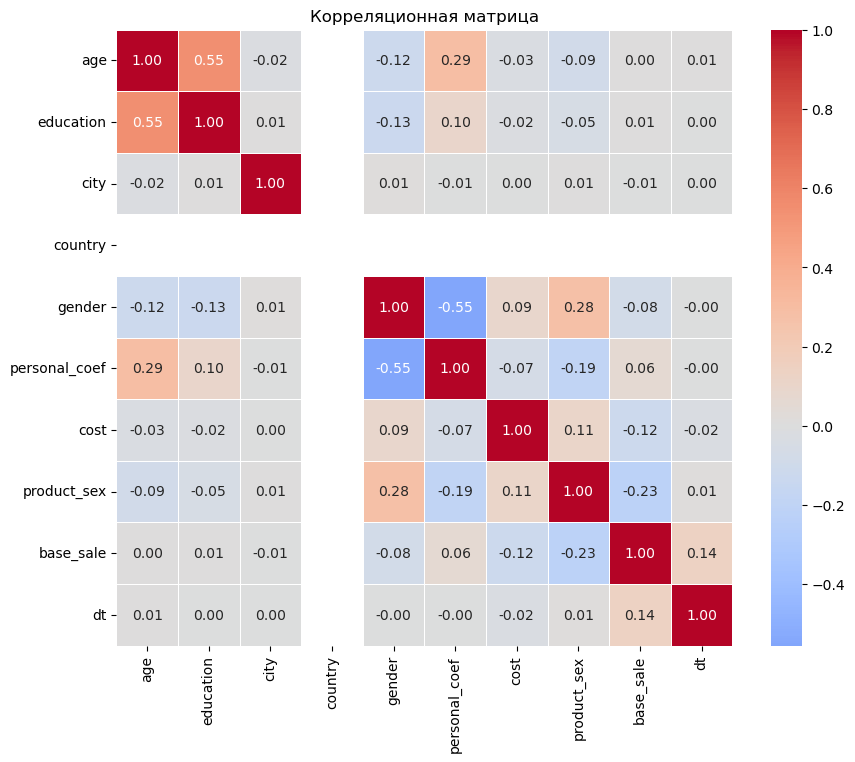

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
# Визуализация корреляционной матрицы с помощью Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0, square=True, linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()

#  3. Проведение A/B-тестирования

In [233]:
def read_custom_file(file_path):
    with open(file_path, 'r') as file:
        # Читаем первую строку
        first_line = file.readline().strip()
        
        # Используем регулярное выражение для разделения буквенной части (заголовка) и числовой части
        match = re.match(r'([A-Za-z\s]+)(.*)', first_line)
        if match:
            header = match.group(1).strip()  # Заголовок - буквенная часть
            first_line_values = match.group(2).strip()  # Числовая часть
        else:
            raise ValueError("Невозможно выделить заголовок и значения из первой строки")
        
        # Читаем оставшиеся строки
        data = file.read().strip()
        
        # Объединяем числовую часть первой строки и остальные строки
        all_values = first_line_values + " " + data
        
    # Разделяем данные по любому из разделителей: запятая, точка с запятой или пробел
    values = re.split(r'[ ,;]+', all_values.strip())

    # Создаем DataFrame с одним столбцом и всеми значениями
    df = pd.DataFrame({header: values})
    return df

In [234]:
# Пользователи, которым предоставили скидку
file_path = r'D:\DO_NOT_REMOVE\Data_Analyst_Junior\FP\result_data\ids_first_company_positive.txt'
ids_first_company_positive_df = read_custom_file(file_path)
ids_first_company_positive_df.head()

,Ids of positive AB people
0,88128
1,171960
2,142117
3,114589
4,146123


In [235]:
ids_first_company_positive_df.shape

(5001, 1)

In [236]:
# Пользователи, которым НЕ предоставили скидку
file_path = r'D:\DO_NOT_REMOVE\Data_Analyst_Junior\FP\result_data\ids_first_company_negative.txt'
ids_first_company_negative_df = read_custom_file(file_path)
ids_first_company_negative_df.head()

,Ids of negative AB people
0,82450
1,63400
2,7138
3,102118
4,153511


In [237]:
ids_first_company_negative_df.shape

(5000, 1)

In [238]:
ids_first_company_positive_df['Ids of positive AB people'].nunique(), ids_first_company_negative_df['Ids of negative AB people'].nunique()

(5001, 5000)

In [239]:
clean_ids_first_company_positive_df = ids_first_company_positive_df.copy()
clean_ids_first_company_negative_df = ids_first_company_negative_df.copy()

In [240]:
# Преобразование значений в clean_ids_first_company_***_df в целочисленный тип (если это возможно)
clean_ids_first_company_positive_df['Ids of positive AB people'] = pd.to_numeric(clean_ids_first_company_positive_df['Ids of positive AB people'], errors='coerce')
clean_ids_first_company_negative_df['Ids of negative AB people'] = pd.to_numeric(clean_ids_first_company_negative_df['Ids of negative AB people'], errors='coerce')

In [241]:
clean_ids_first_company_positive_df.shape, clean_ids_first_company_negative_df.shape

((5001, 1), (5000, 1))

In [242]:
ids_first_company_positive_df['Ids of positive AB people'].nunique(), ids_first_company_negative_df['Ids of negative AB people'].nunique()

(5001, 5000)

In [243]:
# Удаление возможных NaN после преобразования и приведение к целочисленному типу
clean_ids_first_company_positive_df = clean_ids_first_company_positive_df.dropna().astype(int)
clean_ids_first_company_negative_df = clean_ids_first_company_negative_df.dropna().astype(int)

In [244]:
clean_ids_first_company_positive_df['Ids of positive AB people'].nunique(), clean_ids_first_company_negative_df['Ids of negative AB people'].nunique()

(4975, 4976)

In [246]:
# Фильтрация данных ( отбор по id)
positive_filtered_df = data_for_analysis[data_for_analysis['id'].isin(clean_ids_first_company_positive_df['Ids of positive AB people'])]
negative_filtered_df = data_for_analysis[data_for_analysis['id'].isin(clean_ids_first_company_negative_df['Ids of negative AB people'])]

In [247]:
# Данные по тем пользователям, которые совершили покупку во время маркетинговой компании
positive_with_dt = positive_filtered_df[positive_filtered_df['dt'].between(5, 16)]
negative_with_dt = negative_filtered_df[negative_filtered_df['dt'].between(5, 16)]

In [248]:
positive_with_dt.shape,negative_with_dt.shape

((24875, 18), (19820, 18))

### Расчет метрик

In [249]:
 # Общая группа пользователей со скидкой
total_users_with_discount = ids_first_company_positive_df['Ids of positive AB people'].nunique()

In [250]:
# Общая группа пользователей без скидки
total_users_without_discount = ids_first_company_negative_df['Ids of negative AB people'].nunique()

In [251]:
# Подсчет уникальных пользователей
buyers_with_discount = positive_with_dt['id'].nunique()
buyers_without_discount = negative_with_dt['id'].nunique()

In [252]:
# Подсчет общего дохода
total_revenue_with_discount = positive_with_dt['cost'].sum()
total_revenue_without_discount = negative_with_dt['cost'].sum()

In [253]:
# Конверсия
conversion_with_discount = buyers_with_discount / total_users_with_discount
conversion_without_discount = buyers_without_discount / total_users_without_discount

In [254]:
# Средний чек
average_order_value_with_discount = total_revenue_with_discount / buyers_with_discount
average_order_value_without_discount = total_revenue_without_discount / buyers_without_discount

In [256]:
# Вывод метрик
print(f"Общая группа пользователей со скидкой, человек: {total_users_with_discount}")
print(f"Общая группа пользователей без скидки, человек: {total_users_without_discount}")
print(f"Количество уникальных пользователей (со скидкой): {buyers_with_discount}")
print(f"Количество уникальных пользователей (без скидки): {buyers_without_discount}")
print(f"Общий доход (со скидкой): {total_revenue_with_discount}")
print(f"Общий доход (без скидки): {total_revenue_without_discount}")
print(f"Конверсия (со скидкой): {conversion_with_discount:.2%}")
print(f"Конверсия (без скидки): {conversion_without_discount:.2%}")
print(f"Средний чек (со скидкой): {average_order_value_with_discount:.2f}")
print(f"Средний чек (без скидки): {average_order_value_without_discount:.2f}")

Общая группа пользователей со скидкой, человек: 5001
Общая группа пользователей без скидки, человек: 5000
Количество уникальных пользователей (со скидкой): 4750
Количество уникальных пользователей (без скидки): 4935
Общий доход (со скидкой): 132156647
Общий доход (без скидки): 110753333
Конверсия (со скидкой): 94.98%
Конверсия (без скидки): 98.70%
Средний чек (со скидкой): 27822.45
Средний чек (без скидки): 22442.42


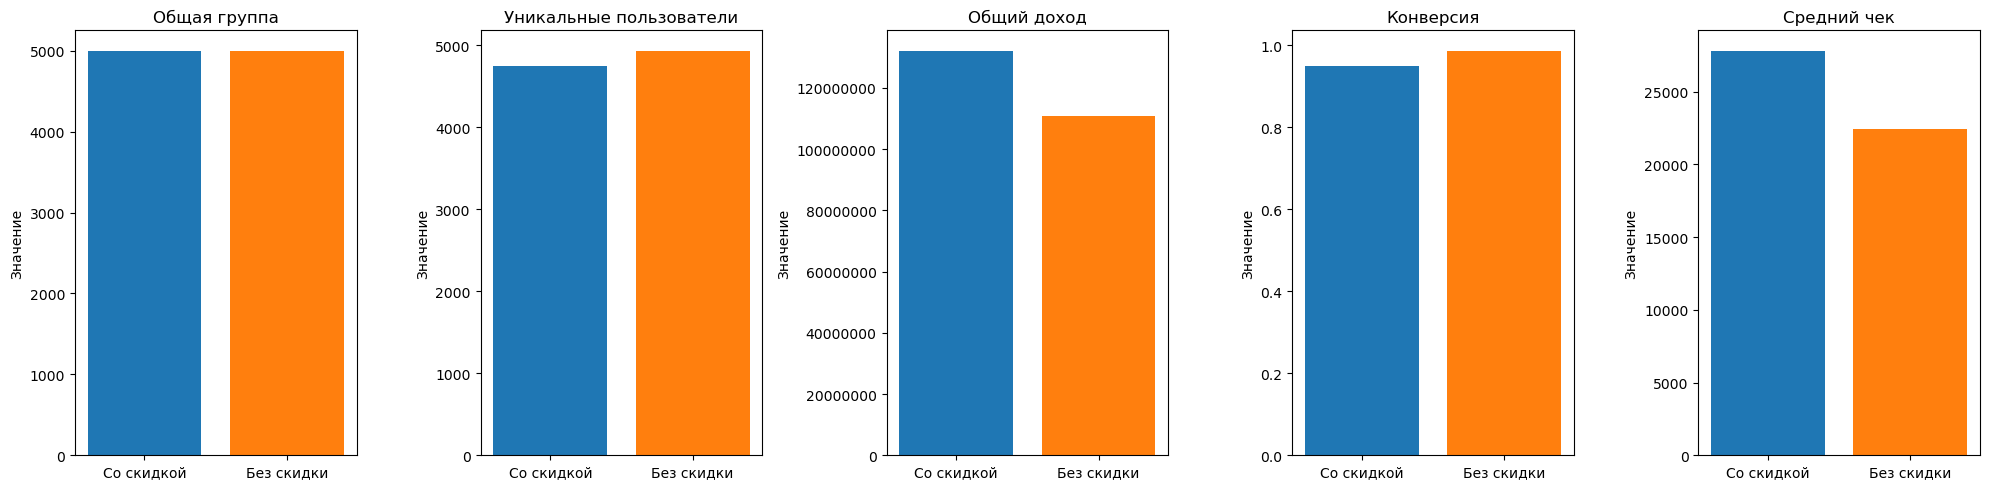

In [261]:
# Данные
categories = ['Общая группа', 'Уникальные пользователи', 'Общий доход', 'Конверсия', 'Средний чек']
with_discount = [total_users_with_discount,buyers_with_discount, total_revenue_with_discount, 
                 conversion_with_discount, average_order_value_with_discount]
without_discount = [total_users_without_discount, buyers_without_discount, total_revenue_without_discount,
                    conversion_without_discount, average_order_value_without_discount]

# Создание подграфиков
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Настройка цветов и заголовков
colors = ['#1f77b4', '#ff7f0e']  # Цвета для групп со скидкой и без скидки

for i, ax in enumerate(axs):
    ax.bar(['Со скидкой', 'Без скидки'], [with_discount[i], without_discount[i]], color=colors)
    ax.set_title(categories[i])
    ax.set_ylabel('Значение')
    ax.set_xticks(['Со скидкой', 'Без скидки'])
    if categories[i] in ['Общий доход', 'Средний чек']:
        ax.ticklabel_format(style='plain', axis='y')  # Отключение научного формата

plt.tight_layout()
plt.show()

### Статистическое тестирование

In [262]:
# Статистический тест для проверки значимости разницы в конверсии
total_users = total_users_with_discount+ total_users_without_discount

In [263]:
# Z-тест для конверсии
z_stat, p_value_conversion = proportions_ztest([buyers_with_discount, buyers_without_discount], total_users)

In [264]:
# T-тест для среднего чека
t_stat, p_value_aov = ttest_ind(positive_with_dt['cost'], negative_with_dt['cost'])

In [265]:
# Вывод результатов тестов
print("\nZ-тест для конверсии")
print(f"Z-статистика: {z_stat:.2f}, p-значение: {p_value_conversion:.4f}")

print("\nT-тест для среднего чека")
print(f"T-статистика: {t_stat:.2f}, p-значение: {p_value_aov:.4f}")


Z-тест для конверсии
Z-статистика: -2.62, p-значение: 0.0089

T-тест для среднего чека
T-статистика: -3.11, p-значение: 0.0019


### Оценка и рекомендации

In [266]:
# Рекомендации
if p_value_conversion < 0.05:
    print("\nРазница в конверсии статистически значима.")
else:
    print("\nРазница в конверсии не является статистически значимой.")

if p_value_aov < 0.05:
    print("Разница в среднем чеке статистически значима.")
else:
    print("Разница в среднем чеке не является статистически значимой.")


Разница в конверсии статистически значима.
Разница в среднем чеке статистически значима.


 Z-тест для конверсии
 
Низкое p-значение (< 0.05) указывает на то, что разница в конверсии между пользователями со скидкой и без скидки статистически значима.

Отрицательная Z-статистика показывает, что конверсия в группе со скидкой ниже, чем в группе без скидки.

Следовательно, несмотря на значительную долю пользователей со скидкой, пользователи без скидки конвертируются в покупки эффективнее.

 T-тест для среднего чека
 
T-статистика равна -3.11 с p-значением 0.0019. Низкое p-значение (< 0.05) указывает на то, что различие в среднем чеке между пользователями со скидкой и без скидки статистически значимо.

Отрицательная T-статистика показывает, что средний чек для пользователей со скидкой выше, чем для пользователей без скидки.

Это свидетельствует о том, что пользователи, получившие скидку, тратят в среднем больше, что может свидетельствовать об эффективности скидок для увеличения дохода с покупок.

##  Бизнес-рекомендации по результатам A/B-теста маркетинговой кампании

Конверсия

Вывод: Группа пользователей со скидкой показала значимо более низкую конверсию (94.98%) по сравнению с группой без скидки (98.70%) на основе Z-теста (Z-статистика = -2.62, p-значение = 0.0089). Это говорит о том, что предложение скидок, вероятно, не побудило больше пользователей совершить покупку, а в некоторых случаях могло снизить мотивацию.

Рекомендация: Необходимо пересмотреть стратегию скидок. Возможно, скидка воспринимается не как стимул, а наоборот, как снижающее восприятие ценности продукта предложение. Альтернативным решением может стать тестирование других типов стимулов, например, программ лояльности, бесплатных подарков или бонусов.

Средний чек

Вывод: Средний чек среди пользователей со скидкой оказался выше (27,822.45) по сравнению с пользователями без скидки (22,442.42). T-тест для этой метрики показал статистически значимую разницу (T-статистика = -3.11, p-значение = 0.0019).

Рекомендация: Хотя скидка не улучшила конверсию, она привела к увеличению среднего чека. Это может означать, что пользователи, решившие совершить покупку, предпочитают делать более крупные заказы. Для увеличения продаж можно внедрить предложения «купи больше, получи больше», пакетные предложения или скидки на следующий заказ.

Общий доход

Вывод: Несмотря на более высокий средний чек в группе со скидкой, общий доход был выше в группе без скидки. Это связано с более высокой конверсией среди пользователей без скидок.

Рекомендация: Возможно, стоит пересмотреть политику предложений и учитывать влияние скидок на общее количество покупок. Например, тестирование динамических скидок в зависимости от суммы заказа или применение персонализированных предложений на основе поведения пользователей.

Общие выводы и стратегия

Скидочная стратегия неэффективна для увеличения объема покупателей, но эффективна для повышения среднего чека.
Рекомендуется провести дополнительное тестирование альтернативных стимулов, которые будут влиять на конверсию, и при необходимости пересмотреть ценовую стратегию для долгосрочного увеличения прибыли.
Инвестиции в дополнительные механизмы удержания клиентов, такие как программы лояльности, могли бы повысить ценность клиента без необходимости значительного снижения цен.

# 4. Кластерный анализ

In [267]:
data_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780117 entries, 0 to 786259
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   id             780117 non-null  int64   
 1   age            780117 non-null  int64   
 2   education      780117 non-null  category
 3   city           780117 non-null  category
 4   country        780117 non-null  category
 5   gender         780117 non-null  category
 6   personal_coef  780117 non-null  float64 
 7   product        780117 non-null  object  
 8   colour         780117 non-null  object  
 9   cost           780117 non-null  int64   
 10  product_sex    780117 non-null  category
 11  base_sale      780117 non-null  category
 12  dt             780117 non-null  int64   
 13  colour_1       780117 non-null  object  
 14  colour_2       780117 non-null  object  
 15  colour_3       780117 non-null  object  
 16  colour_4       780117 non-null  object  
 17  colour_5       

In [268]:
data_for_analysis.reset_index(drop=True, inplace=True)

In [291]:
data_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780117 entries, 0 to 780116
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   id             780117 non-null  int64   
 1   age            780117 non-null  int64   
 2   education      780117 non-null  category
 3   city           780117 non-null  category
 4   country        780117 non-null  category
 5   gender         780117 non-null  category
 6   personal_coef  780117 non-null  float64 
 7   product        780117 non-null  object  
 8   colour         780117 non-null  object  
 9   cost           780117 non-null  int64   
 10  product_sex    780117 non-null  category
 11  base_sale      780117 non-null  category
 12  dt             780117 non-null  int64   
 13  colour_1       780117 non-null  object  
 14  colour_2       780117 non-null  object  
 15  colour_3       780117 non-null  object  
 16  colour_4       780117 non-null  object  
 17  colour_5  

In [292]:
# Выбираем числовые признаки для кластеризации
features = ['age', 'education','gender', 'product_sex','cost','base_sale', 'dt']
X = data_for_analysis[features]

In [293]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [294]:
# Определение оптимального количества кластеров с помощью метода локтя
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

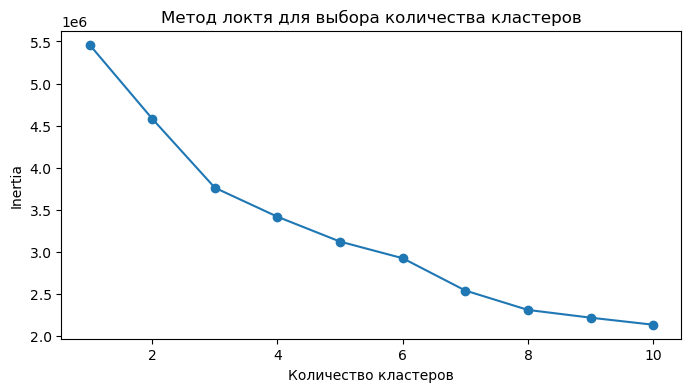

In [295]:
# Визуализация метода локтя
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для выбора количества кластеров')
plt.show()

In [296]:
# Кластеризация на основе выбранного количества кластеров
optimal_clusters = 6  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
data_for_analysis['cluster'] = clusters

In [297]:
# Анализ кластеров
for i in range(optimal_clusters):
    cluster_data = data_for_analysis[data_for_analysis['cluster'] == i]
    print(f"\nКластер {i}")
    print(f"Средний возраст: {cluster_data['age'].mean():.2f}")
    print(f"Средняя стоимость покупки: {cluster_data['cost'].mean():.2f}")
    print(f"Предпочтительные товары: {cluster_data['product'].mode().values}")
    print(f"Влияние скидки: {cluster_data['base_sale'].value_counts()}")


Кластер 0
Средний возраст: 40.97
Средняя стоимость покупки: 4451.12
Предпочтительные товары: ['Сумка FILA']
Влияние скидки: base_sale
0    64596
1    17301
Name: count, dtype: int64

Кластер 1
Средний возраст: 41.68
Средняя стоимость покупки: 4734.31
Предпочтительные товары: ['Брюки мужские Demix']
Влияние скидки: base_sale
0    73153
1    62713
Name: count, dtype: int64

Кластер 2
Средний возраст: 42.76
Средняя стоимость покупки: 3150.17
Предпочтительные товары: ['Футболка женская Demix']
Влияние скидки: base_sale
1    117150
0         0
Name: count, dtype: int64

Кластер 3
Средний возраст: 41.21
Средняя стоимость покупки: 7854.77
Предпочтительные товары: ['Брюки мужские Demix']
Влияние скидки: base_sale
0    162938
1     29983
Name: count, dtype: int64

Кластер 4
Средний возраст: 43.68
Средняя стоимость покупки: 4592.21
Предпочтительные товары: ['Брюки женские Outventure']
Влияние скидки: base_sale
0    105656
1         0
Name: count, dtype: int64

Кластер 5
Средний возраст: 23.37
С

In [288]:
# PCA для уменьшения размерности до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

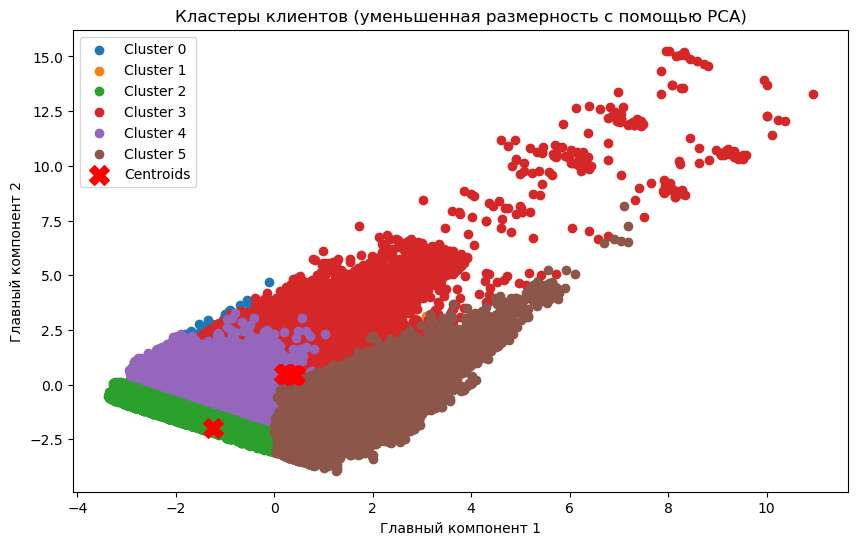

In [298]:
# Визуализация кластеров
plt.figure(figsize=(10, 6))
for cluster_num in range(optimal_clusters):
    plt.scatter(
        X_pca[clusters == cluster_num, 0], 
        X_pca[clusters == cluster_num, 1], 
        label=f'Cluster {cluster_num}'
    )

plt.scatter(
    kmeans.cluster_centers_[:, 0], 
    kmeans.cluster_centers_[:, 1], 
    s=200, c='red', label='Centroids', marker='X'
)
plt.title('Кластеры клиентов (уменьшенная размерность с помощью PCA)')
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.legend()
plt.show()

### Выводы:

Кластер 0:

Средний возраст: 40.97 лет.
Средняя стоимость покупки: 4451.12.
Предпочтительные товары: Сумка FILA.
Влияние скидки: Большинство покупок совершается без скидки.
Рекомендации: Этот кластер состоит из покупателей среднего возраста, которые предпочитают аксессуары. Можно предложить новые модели сумок и акцентировать внимание на качестве и функциональности товаров.

Кластер 1:

Средний возраст: 41.68 лет.
Средняя стоимость покупки: 4734.31.
Предпочтительные товары: Брюки мужские Demix.
Влияние скидки: Практически равное распределение покупок со скидкой и без.
Рекомендации: Учитывая интерес к мужской одежде, стоит внедрить кампании, включающие скидки, и регулярно обновлять ассортимент спортивной одежды для мужчин.

Кластер 2:

Средний возраст: 42.76 лет.
Средняя стоимость покупки: 3150.17.
Предпочтительные товары: Футболка женская Demix.
Влияние скидки: Все покупки совершаются исключительно по скидке.
Рекомендации: Этот кластер сильно реагирует на скидки. Для их привлечения стоит регулярно предлагать акции на женскую одежду, особенно спортивные футболки.

Кластер 3:

Средний возраст: 41.21 года.
Средняя стоимость покупки: 7854.77.
Предпочтительные товары: Брюки мужские Demix.
Влияние скидки: Большинство покупок совершается без скидок.
Рекомендации: Это платежеспособная аудитория, предпочитающая мужскую одежду. Им стоит предлагать премиальные коллекции и подчеркивать качество товаров.

Кластер 4:

Средний возраст: 43.68 года.
Средняя стоимость покупки: 4592.21.
Предпочтительные товары: Брюки женские Outventure.
Влияние скидки: Все покупки совершаются без скидок.
Рекомендации: Этот кластер ценит женскую одежду высокого качества. Можно предложить эксклюзивные коллекции или индивидуальные услуги, такие как персонализированные подборки.

Кластер 5:

Средний возраст: 23.37 года.
Средняя стоимость покупки: 5763.02.
Предпочтительные товары: Шорты мужские Demix.
Влияние скидки: Покупки равномерно распределяются между скидками и их отсутствием.
Рекомендации: Молодая аудитория, активно интересующаяся мужской одеждой. Для них можно использовать современные маркетинговые подходы, такие как таргетированная реклама в соцсетях, и акцент на новинках ассортимента.

# 5. Mодель склонности клиента к покупке определённого товара для жителей страны 32 города 1 188

In [299]:
# Отбор данных
filtered_data = data_for_analysis[(data_for_analysis['city'] == 1188) & (data_for_analysis['country'] == 32)]
filtered_data.shape

(88889, 19)

In [300]:
# Создаем целевую переменную (предположительно бинарная: 1 - покупка, 0 - нет)
filtered_data.loc[:, 'purchase'] = (filtered_data['cost'] > 0).astype(int)

C:\Users\felix\AppData\Local\Temp\ipykernel_17092\600278397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'purchase'] = (filtered_data['cost'] > 0).astype(int)


In [301]:
filtered_data.columns

Index(['id', 'age', 'education', 'city', 'country', 'gender', 'personal_coef',
       'product', 'colour', 'cost', 'product_sex', 'base_sale', 'dt',
       'colour_1', 'colour_2', 'colour_3', 'colour_4', 'colour_5', 'cluster',
       'purchase'],
      dtype='object')

In [302]:
# Выбираем признаки для обучения модели
features = ['age', 'gender', 'dt', 'cluster', 'product_sex']
X = filtered_data[features]
y = filtered_data['purchase']

In [303]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [304]:
# Обучение модели
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [305]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     26667

    accuracy                           1.00     26667
   macro avg       0.50      0.50      0.50     26667
weighted avg       1.00      1.00      1.00     26667



C:\Users\felix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [306]:
# Создаем стратифицированный k-фолд
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [307]:
# Оценка модели с использованием стратифицированной кросс-валидации
cross_val_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f"Cross-validated accuracy scores: {cross_val_scores}")
print(f"Mean cross-validated accuracy: {cross_val_scores.mean():.2f}")

C:\Users\felix\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-validated accuracy scores: [1.         0.99996625 0.99996625]
Mean cross-validated accuracy: 1.00


In [308]:
# Вывод значимости признаков
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.2f}")

age: 0.60
gender: 0.00
dt: 0.32
cluster: 0.02
product_sex: 0.06


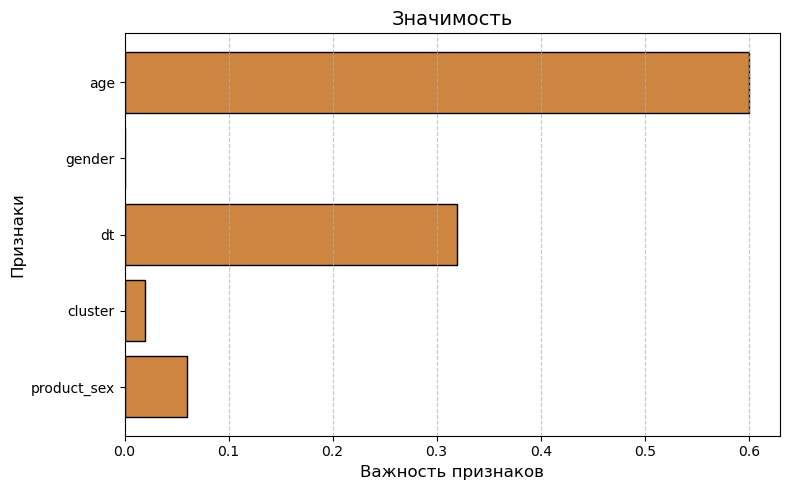

In [8]:
# Данные для значимости признаков
features = ['age', 'gender', 'dt', 'cluster', 'product_sex']
feature_importances = [0.60, 0.00, 0.32, 0.02, 0.06]

# Построение графика
plt.figure(figsize=(8, 5))
plt.barh(features, feature_importances, color='#CD853F', edgecolor='black')
plt.xlabel("Важность признаков", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.title("Значимость", fontsize=14)
plt.gca().invert_yaxis()  # Перевернуть ось Y для удобства
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [309]:
# Предсказания вероятностей для тестовых данных
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Получаем вероятности для класса "покупка" (1)
